In [2]:
#载入包

import numpy as np
import pandas as pd
import os
from pandas import Series,DataFrame
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm
import math
import datetime
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
import sklearn.metrics as sklm
from sklearn.metrics import confusion_matrix
import sklearn.cluster as sklc
import seaborn as sn
import scipy
from scipy.stats import pearsonr
import arcpy
import geopandas
from warnings import simplefilter

simplefilter(action='ignore', category=Warning)

%matplotlib inline

In [110]:
#数据清洗与整理
'''
1. 读取原始数据并删除无效行
2. 处理空值并定义部分文本
3. 将部分值以判断有无进行呈现(license_tf,host_location_tf)
4. 将部分值以定量方法进行呈现(host_verification_num,amenities_num)
5. 计算房东加入Airbnb的时间(host_duration)
6. 热门程度指数计算(pop_past,pop_future,popularity)
7. 删除无效变量
8. 输出清洗后数据
'''

#读取原始数据并删除无效行
listings_data = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/listings.csv')
#drop columns and select points in Seattle
listings_data_1 = listings_data.drop(labels=['name','description','neighborhood_overview','neighbourhood','host_thumbnail_url','host_picture_url','picture_url','calendar_last_scraped','host_url','host_name','host_about','scrape_id', 'last_scraped', 'source', 'listing_url', 'host_neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'calendar_updated', 'availability_60','availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review','calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'host_listings_count', 'host_total_listings_count'], axis=1)
listings_seattle= listings_data_1.drop(listings_data_1[listings_data_1['has_availability'] == 'f'].index)
listings_seattle.reset_index(drop=True,inplace=True)

#Dealing with null values and defining partial text
listings_seattle['reviews_per_month'] = listings_seattle['reviews_per_month'].replace([np.nan],0)
listings_seattle['bathrooms_text'] = listings_seattle['bathrooms_text'].replace([np.nan],'0')
listings_seattle['bathrooms'] = listings_seattle['bathrooms_text'].str.split('\s+').str[0]
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].replace('half-bath',0.5)
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].replace('Half-bath',0.5)
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].replace('Shared',0.5)
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].replace([np.nan],0)
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].astype(float)
listings_seattle['bedrooms'] = listings_seattle['bedrooms'].replace([np.nan],0)
listings_seattle['host_location'] = listings_seattle['host_location'].replace([np.nan],' ')
listings_seattle['host_response_time'] = listings_seattle['host_response_time'].replace([np.nan],'No response')
listings_seattle['host_response_rate'] = listings_seattle['host_response_rate'].replace([np.nan],'0')
listings_seattle['host_response_rate'] = listings_seattle['host_response_rate'].str.split('%').str[0]
listings_seattle['host_response_rate'] = listings_seattle['host_response_rate'].astype(int)
listings_seattle['host_acceptance_rate'] = listings_seattle['host_acceptance_rate'].replace([np.nan],'0')
listings_seattle['host_acceptance_rate'] = listings_seattle['host_acceptance_rate'].str.split('%').str[0]
listings_seattle['host_acceptance_rate'] = listings_seattle['host_acceptance_rate'].astype(float)
listings_seattle['price']=listings_seattle['price'].str.replace('$','')
listings_seattle['price']=listings_seattle['price'].str.replace(',','')
listings_seattle['price']=listings_seattle['price'].astype(float)
listings_seattle_1 = listings_seattle.drop(listings_data_1[listings_data_1['price'] == 0].index)
listings_seattle_1.reset_index(drop=True,inplace=True)
listings_seattle_1['license'] = listings_seattle_1['license'].str.contains('S',na = False)
listings_seattle_1 = listings_seattle_1.dropna(axis=0, how = 'any', subset =["host_is_superhost","minimum_nights_avg_ntm","beds","review_scores_value"])
#host_response_time
response_dic = {"No response":1,
               "a few days or more":2,
               "within a day":3,
               "within a few hours":4,
               "within an hour":5}
listings_seattle_1['response_time_num'] = 0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['response_time_num'].iloc[i] = response_dic[listings_seattle_1['host_response_time'].iloc[i]]
#'No response'-1
#'a few days or more'-2
#'within a day'-3
#'within a few hours'-4
#'within an hour' -5
#room_type
type_dic = {"Shared room":1,
            'Hotel room':2,
            "Private room":2,
            "Entire home/apt":3}
listings_seattle_1['type_num'] = 0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['type_num'].iloc[i] = type_dic[listings_seattle_1['room_type'].iloc[i]]
#'Shared room'-1
#'Hotel room'-2
#'Private room'-2
#'Entire home/apt'-3

#license_tf
listings_seattle_1['license_tf'] = 0
for i in range(len(listings_seattle_1)):
    if listings_seattle_1['license'].iloc[i] == False:
        listings_seattle_1['license_tf'].iloc[i]='f'
    else:
        listings_seattle_1['license_tf'].iloc[i]='t'
#host_location_tf
listings_seattle_1['host_location_tf'] = 0
listings_seattle_1['host_location_tf'] = listings_seattle_1['host_location'].str.contains('Seattle',na = False)
for i in range(len(listings_seattle_1)):
    if listings_seattle_1['host_location_tf'].iloc[i] == False:
        listings_seattle_1['host_location_tf'].iloc[i]='f'
    else:
        listings_seattle_1['host_location_tf'].iloc[i] = 't'

#host_verfications个数, host_verification_num, int格式
listings_seattle_1['host_verifications_num']=0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['host_verifications_num'].iloc[i] = (listings_seattle_1['host_verifications'].iloc[i]).count(',')+1
#amenities个数, amenities_num, int格式
listings_seattle_1['amenities_num']=0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['amenities_num'].iloc[i] = (listings_seattle_1['amenities'].iloc[i]).count(',')+1

#计算房东加入Airbnb的时间(host_duration)
listings_seattle_1['present_time'] = datetime.date.today()
listings_seattle_1['start_time'] = ''
listings_seattle_1['host_duration'] = ''
for i in range(len(listings_seattle_1)):
    listings_seattle_1['start_time'].iloc[i] = datetime.datetime.strptime(str(listings_seattle_1['host_since'].iloc[i]), '%Y-%m-%d').date()
    listings_seattle_1['host_duration'].iloc[i] = (listings_seattle_1['present_time'].iloc[i] - listings_seattle_1['start_time'].iloc[i]).days

#Calculating the popularity(pop_past,pop_future,popularity)
#booked_30=30-availability_30
listings_seattle_1['book_30']=0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['book_30'].iloc[i] = 30-listings_seattle_1['availability_30'].iloc[i]
#popularity：The average number of comments per month is normalised to past popularity and the number of scheduled days in the coming month is normalised to expected popularity, and the two are added together to obtain
#standardization,from lecture week6 P83
reviews_monthly_mean = listings_seattle_1['reviews_per_month'].mean()
reviews_monthly_mean = round (reviews_monthly_mean,2)
reviews_monthly_std = listings_seattle_1['reviews_per_month'].std()
reviews_monthly_std = round (reviews_monthly_std,2)
book30_mean = listings_seattle_1['book_30'].mean()
book30_mean = round(book30_mean,2)
book30_std = listings_seattle_1['book_30'].std()
book30_std = round(book30_std,2)
listings_seattle_1['pop_past'] = 0
listings_seattle_1['pop_future'] = 0
listings_seattle_1['popularity'] = 0
#pop_past
for i in range(len(listings_seattle_1)):
    listings_seattle_1['pop_past'].iloc[i] = (listings_seattle_1['reviews_per_month'].iloc[i]-reviews_monthly_mean)/reviews_monthly_std
    listings_seattle_1['pop_past'].iloc[i] = round (listings_seattle_1['pop_past'].iloc[i],2)
#pop_future
    listings_seattle_1['pop_future'].iloc[i] = (listings_seattle_1['book_30'].iloc[i]-book30_mean)/book30_std
    listings_seattle_1['pop_future'].iloc[i] = round (listings_seattle_1['pop_future'].iloc[i],2)
#popularity
    listings_seattle_1['popularity'].iloc[i] = listings_seattle_1['pop_past'].iloc[i] + listings_seattle_1['pop_future'].iloc[i] 

#删除无效变量
listings_seattle_final = listings_seattle_1
listings_seattle_clean = listings_seattle_1.drop(labels=['host_since','host_location','host_response_time','host_verifications','bathrooms_text','amenities','has_availability','license','present_time','start_time','property_type','room_type','availability_30','book_30','reviews_per_month'], axis=1)

#输出清洗后数据
listings_seattle_final.to_csv('listings_final.csv',index=False,header=True)
listings_seattle_clean.to_csv('listings_clean.csv',index=False,header=True)

In [111]:
#Spatial Analysis
#Created by Modelbuilder
#POI source: Openstreetmap

'''
1. Calculate the number of public transport stops in the vicinity (0.5km)
2. Calculate the number of POIs in the vicinity (0.5km)
3. Calculate the number of hotels in the vicinity (0.5km)
4. Calculate the number of rooms in the vicinity (0.5km) and their average price
5. Calculate the distance to the nearest attraction
6. Calculate the distance to the city centre
'''

def spatial_analysis():

    arcpy.env.overwriteOutput = True

    arcpy.ImportToolbox(r"c:\program files\arcgis\pro\Resources\ArcToolbox\toolboxes\Data Management Tools.tbx")
    listings_clean_csv = "D:\\UCL_CODE\\CASA0007\\work\\Group\\listings_clean.csv"
    poi_shp = "D:\\UCL_CODE\\Data\\POI\\poi.shp"
    places_shp = "D:\\UCL_CODE\\Data\\POI\\places.shp"
    transport_shp = "D:\\UCL_CODE\\Data\\POI\\transport.shp"
    Group = "D:\\UCL_CODE\\CASA0007\\work\\Group"
    
    # Process: XY Table To Point (XY Table To Point) (management)
    airbnb = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb"
    arcpy.management.XYTableToPoint(in_table=listings_clean_csv, out_feature_class=airbnb, x_field="longitude", y_field="latitude", z_field="",
                                    coordinate_system="GEOGCS[\"GCS_WGS_1984\",DATUM[\"D_WGS_1984\",SPHEROID[\"WGS_1984\",6378137.0,298.257223563]],PRIMEM[\"Greenwich\",0.0],UNIT[\"Degree\",0.0174532925199433]];-400 -400 1000000000;-100000 10000;-100000 10000;8.98315284119521E-09;0.001;0.001;IsHighPrecision")

    # Process: Select (Select) (analysis)
    poi_attractions = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\poi_attractions"
    arcpy.analysis.Select(
        in_features=poi_shp, out_feature_class=poi_attractions, where_clause="code = 2721")

    # Process: Near (Near) (analysis)
    airbnb_4_ = arcpy.analysis.Near(in_features=airbnb, near_features=[
                                    poi_attractions], search_radius="", location="NO_LOCATION", angle="NO_ANGLE", method="GEODESIC", field_names=[["NEAR_DIST", "dist_attractions"]])[0]

    # Process: Select (Select) (analysis)
    Seattle = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\Seattle"
    arcpy.analysis.Select(in_features=places_shp, out_feature_class=Seattle,
                          where_clause="fclass = 'city' And name = 'Seattle'")

    # Process: Near (Near) (analysis)
    airbnb_9_ = arcpy.analysis.Near(in_features=airbnb_4_, near_features=[
                                    Seattle], search_radius="", location="NO_LOCATION", angle="NO_ANGLE", method="GEODESIC", field_names=[["NEAR_DIST", "dist_city"]])[0]

    # Process: Buffer (Buffer) (analysis)
    airbnb_Buffer = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb_Buffer"
    arcpy.analysis.Buffer(in_features=airbnb, out_feature_class=airbnb_Buffer, buffer_distance_or_field="0.5 Kilometers",
                          line_side="FULL", line_end_type="ROUND", dissolve_option="NONE", dissolve_field=[], method="PLANAR")

    # Process: Spatial Join (Spatial Join) (analysis)
    airbnb_count_and_price = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb_count_and_price"
    arcpy.analysis.SpatialJoin(target_features=airbnb_Buffer, join_features=airbnb, out_feature_class=airbnb_count_and_price, join_operation="JOIN_ONE_TO_ONE", join_type="KEEP_ALL",
                               field_mapping="price \"price\" true true false 8 Double 0 0,Mean,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,price,-1,-1", match_option="INTERSECT", search_radius="", distance_field_name="")

    # Process: Join Field (Join Field) (management)
    airbnb_2_ = arcpy.management.JoinField(in_data=airbnb_9_, in_field="OBJECTID", join_table=airbnb_count_and_price, join_field="OBJECTID", fields=[
    ], fm_option="USE_FM", field_mapping="airbnb_count \"airbnb_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb_count_and_price,Join_Count,-1,-1;average_price \"average_price\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb_count_and_price,price,-1,-1")[0]

    # Process: Spatial Join (Spatial Join) (analysis)
    poi_count = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\poi_count"
    arcpy.analysis.SpatialJoin(target_features=airbnb_Buffer, join_features=poi_shp, out_feature_class=poi_count, join_operation="JOIN_ONE_TO_ONE",
                               join_type="KEEP_ALL", field_mapping="", match_option="INTERSECT", search_radius="", distance_field_name="")

    # Process: Join Field (Join Field) (management)
    airbnb_7_ = arcpy.management.JoinField(in_data=airbnb_2_, in_field="OBJECTID", join_table=poi_count, join_field="OBJECTID", fields=[
    ], fm_option="USE_FM", field_mapping="poi_count \"poi_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\poi_count,Join_Count,-1,-1")[0]

    # Process: Spatial Join (Spatial Join) (analysis)
    transport_count = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\transport_count"
    arcpy.analysis.SpatialJoin(target_features=airbnb_Buffer, join_features=transport_shp, out_feature_class=transport_count,
                               join_operation="JOIN_ONE_TO_ONE", join_type="KEEP_ALL", field_mapping="", match_option="INTERSECT", search_radius="", distance_field_name="")

    # Process: Join Field (Join Field) (management)
    airbnb_6_ = arcpy.management.JoinField(in_data=airbnb_7_, in_field="OBJECTID", join_table=transport_count, join_field="OBJECTID", fields=[
    ], fm_option="USE_FM", field_mapping="transport_count \"transport_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\transport_count,Join_Count,-1,-1")[0]

    # Process: Select (Select) (analysis)
    poi_hotel = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\poi_hotel"
    arcpy.analysis.Select(in_features=poi_shp, out_feature_class=poi_hotel,
                          where_clause="code > 2400 And code < 2420")

    # Process: Spatial Join (Spatial Join) (analysis)
    hotel_count = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\hotel_count"
    arcpy.analysis.SpatialJoin(target_features=airbnb_Buffer, join_features=poi_hotel, out_feature_class=hotel_count, join_operation="JOIN_ONE_TO_ONE",
                               join_type="KEEP_ALL", field_mapping="", match_option="INTERSECT", search_radius="", distance_field_name="")

    # Process: Join Field (Join Field) (management)
    airbnb_5_ = arcpy.management.JoinField(in_data=airbnb_6_, in_field="OBJECTID", join_table=hotel_count, join_field="OBJECTID", fields=[
    ], fm_option="USE_FM", field_mapping="hotel_count \"hotel_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\hotel_count,Join_Count,-1,-1")[0]

    # Process: Delete Field (Delete Field) (management)
    airbnb_8_ = arcpy.management.DeleteField(in_table=airbnb_5_, drop_field=[
                                             "NEAR_FID"], method="DELETE_FIELDS")[0]

    # Process: Table To Table (Table To Table) (conversion)
    spatial_analysis_csv = arcpy.conversion.TableToTable(in_rows=airbnb_8_, out_path=Group, out_name="spatial_analysis.csv", where_clause="",
                                                         field_mapping="id \"id\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,id,-1,-1;host_id \"host_id\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_id,-1,-1;host_response_rate \"host_response_rate\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_response_rate,-1,-1;host_acceptance_rate \"host_acceptance_rate\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_acceptance_rate,-1,-1;host_is_superhost \"host_is_superhost\" true true false 8000 Text 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_is_superhost,0,8000;host_has_profile_pic \"host_has_profile_pic\" true true false 8000 Text 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_has_profile_pic,0,8000;host_identity_verified \"host_identity_verified\" true true false 8000 Text 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_identity_verified,0,8000;latitude \"latitude\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,latitude,-1,-1;longitude \"longitude\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,longitude,-1,-1;accommodates \"accommodates\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,accommodates,-1,-1;bathrooms \"bathrooms\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,bathrooms,-1,-1;bedrooms \"bedrooms\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,bedrooms,-1,-1;beds \"beds\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,beds,-1,-1;price \"price\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,price,-1,-1;minimum_nights_avg_ntm \"minimum_nights_avg_ntm\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,minimum_nights_avg_ntm,-1,-1;maximum_nights_avg_ntm \"maximum_nights_avg_ntm\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,maximum_nights_avg_ntm,-1,-1;review_scores_rating \"review_scores_rating\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_rating,-1,-1;review_scores_accuracy \"review_scores_accuracy\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_accuracy,-1,-1;review_scores_cleanliness \"review_scores_cleanliness\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_cleanliness,-1,-1;review_scores_checkin \"review_scores_checkin\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_checkin,-1,-1;review_scores_communication \"review_scores_communication\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_communication,-1,-1;review_scores_location \"review_scores_location\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_location,-1,-1;review_scores_value \"review_scores_value\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_value,-1,-1;instant_bookable \"instant_bookable\" true true false 8000 Text 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,instant_bookable,0,8000;calculated_host_listings_count \"calculated_host_listings_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,calculated_host_listings_count,-1,-1;response_time_num \"response_time_num\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,response_time_num,-1,-1;type_num \"type_num\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,type_num,-1,-1;license_tf \"license_tf\" true true false 8000 Text 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,license_tf,0,8000;host_location_tf \"host_location_tf\" true true false 8000 Text 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_location_tf,0,8000;host_verifications_num \"host_verifications_num\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_verifications_num,-1,-1;amenities_num \"amenities_num\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,amenities_num,-1,-1;host_duration \"host_duration\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_duration,-1,-1;pop_past \"pop_past\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,pop_past,-1,-1;pop_future \"pop_future\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,pop_future,-1,-1;popularity \"popularity\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,popularity,-1,-1;dist_attractions \"dist_attractions\" true true false 0 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,dist_attractions,-1,-1;dist_city \"dist_city\" true true false 0 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,dist_city,-1,-1;airbnb_count \"airbnb_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,airbnb_count,-1,-1;average_price \"average_price\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,average_price,-1,-1;poi_count \"poi_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,poi_count,-1,-1;transport_count \"transport_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,transport_count,-1,-1;hotel_count \"hotel_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,hotel_count,-1,-1", config_keyword="")[0]

    return(spatial_analysis_csv)

if __name__ == '__main__':
    # Global Environment settings
    with arcpy.EnvManager(scratchWorkspace=r"C:\Users\xianl\Documents\ArcGIS\Projects\CASA0007Group\CASA0007Group.gdb", workspace=r"C:\Users\xianl\Documents\ArcGIS\Projects\CASA0007Group\CASA0007Group.gdb"):
        spatial_analysis()

spatial_analysis = pd.read_csv(spatial_analysis())
spatial_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4932 entries, 0 to 4931
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   OID_                            4932 non-null   int64  
 1   id                              4932 non-null   float64
 2   host_id                         4932 non-null   int64  
 3   host_response_rate              4932 non-null   int64  
 4   host_acceptance_rate            4932 non-null   float64
 5   host_is_superhost               4932 non-null   object 
 6   host_has_profile_pic            4932 non-null   object 
 7   host_identity_verified          4932 non-null   object 
 8   latitude                        4932 non-null   float64
 9   longitude                       4932 non-null   float64
 10  accommodates                    4932 non-null   int64  
 11  bathrooms                       4932 non-null   float64
 12  bedrooms                        49

Unique num of host_id:2964
precent:0.6009732360097324


<AxesSubplot:xlabel='latitude', ylabel='longitude'>

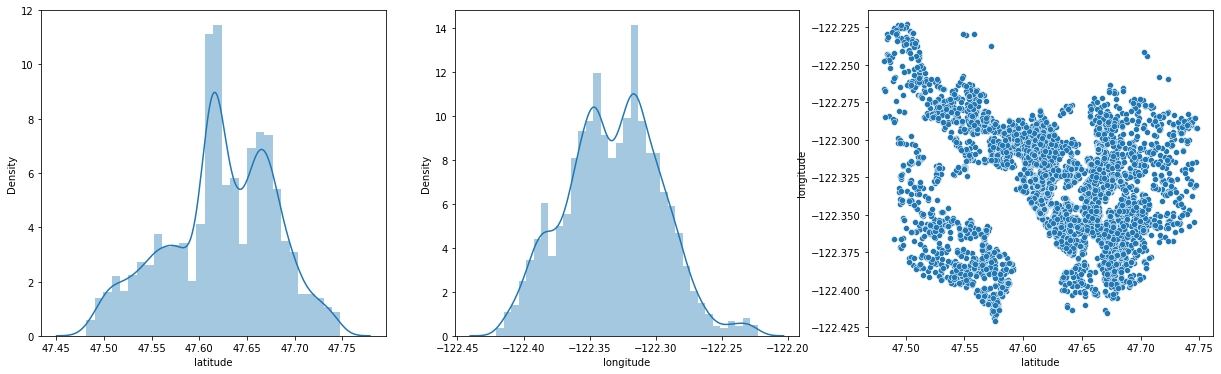

In [112]:
#对host_id进行探索并查看不重复的host_id 的数量
total = len(spatial_analysis['host_id'].unique())
percent = len(spatial_analysis['host_id'].unique())/spatial_analysis.shape[0]
print(f'Unique num of host_id:{total}')
print(f'precent:{percent}')

#latitude and longitude对经纬度分布进行探索
fig, axes = plt.subplots(1,3, figsize=(21,6))
sn.distplot(spatial_analysis['latitude'], ax = axes[0])
sn.distplot(spatial_analysis['longitude'], ax = axes[1])
sn.scatterplot(x = spatial_analysis['latitude'], y = spatial_analysis['longitude'])

[0 0 1 ... 0 0 2]
For n_clusters = 3 The average silhouette_score is : 0.5638873478117749
For n_clusters = 4 The average silhouette_score is : 0.5009703914658085
For n_clusters = 5 The average silhouette_score is : 0.43348910162169624


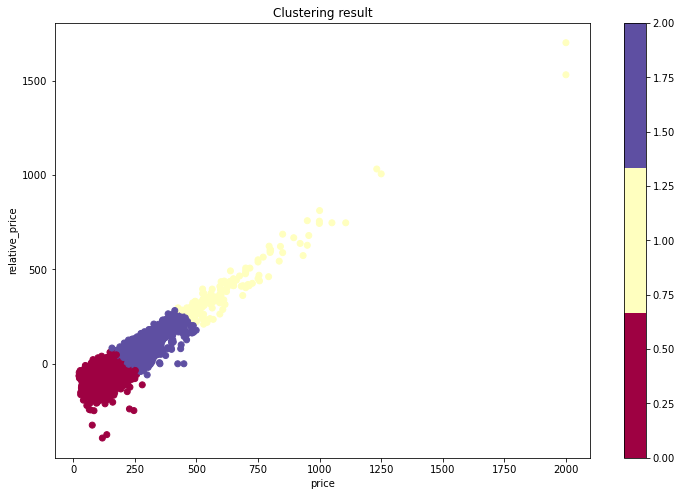

In [113]:
#Clustering of Price

#Read Data
seattle = spatial_analysis

#Relative_Price：Price - Average_Price
seattle['relative_price'] = 0
for i in range(len(seattle['price'])):
    seattle['relative_price'] = seattle['price'] - seattle['average_price']
seattle

#When num_cluster=3, Silhouette Score is the Highest
seattle_sub = seattle.loc[:,['price','relative_price']]
seattle_sub.columns = ['price', 'relative_price']
num_clusters = 3
random_state_seed = 100
kmeans_output = sklc.KMeans(n_clusters = num_clusters, random_state = random_state_seed).fit(seattle_sub)
clustering_ids_kmeans = kmeans_output.labels_
print(clustering_ids_kmeans)
seattle_sub = seattle_sub.assign(cluster_id = clustering_ids_kmeans)

#Plot the Result of Clustering
fig, ax = plt.subplots(figsize = (12,8))
#Number of Clusters
n_clusters = seattle_sub.cluster_id.nunique()
#Get Discrete Colormap
cmap = plt.get_cmap('Spectral',n_clusters)
#Scatter Points
scatter = ax.scatter(seattle_sub.price, seattle_sub.relative_price, c = seattle_sub.cluster_id, cmap = cmap)
ax.set_xlabel('price')
ax.set_ylabel('relative_price')
ax.set_title('Clustering result')
#Add Colorbar
cbar = plt.colorbar(scatter)

#Calculate the Silhouette_Score When num_cluster = 3,4,5
silhouette_kmeans = sklm.silhouette_score(seattle_sub,clustering_ids_kmeans) #(data points,labels of clusters)
df_silhouette_score = pd.DataFrame({'n_cluster':[3,4,5], 'silhouette_score':[0,0,0]})
for index, row in df_silhouette_score.iterrows():
    n_clusters = row['n_cluster']
    clusterer = sklc.KMeans(n_clusters = n_clusters, random_state = random_state_seed).fit(seattle_sub)
    cluster_labels = clusterer.labels_
    # The silhouette_score Gives the Average Value for All the Samples.
    # This Gives a Perspective Into the Density and Separation of the Formed Clusters
    silhouette_avg = sklm.silhouette_score(seattle_sub, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    row['silhouette_score'] = silhouette_avg

#Merge the Data
class_price = pd.concat([seattle, seattle_sub.iloc[:,2]], axis = 1)
#2-highest price
#1-medium price
#0-lowest price

#Output
class_price.to_csv('class_price.csv',index = False,header = True)

Old Shape:  (4932, 45)


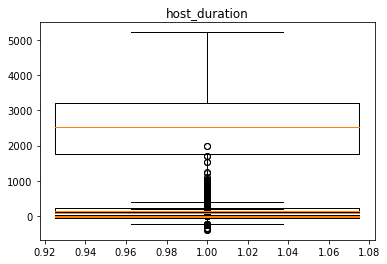

In [114]:
#outlier check
plt.boxplot(class_price['price'], manage_ticks=(False))
plt.title("price")
plt.boxplot(class_price['host_response_rate'], manage_ticks=(False))
plt.title("host_response_rate")
plt.boxplot(class_price['response_time_num'], manage_ticks=(False))
plt.title("response_time_num")
plt.boxplot(class_price['host_verifications_num'], manage_ticks=(False))
plt.title("host_verifications_num")
plt.boxplot(class_price['pop_past'], manage_ticks=(False))
plt.title("pop_past")
plt.boxplot(class_price['pop_future'], manage_ticks=(False))
plt.title("pop_future")
plt.boxplot(class_price['popularity'], manage_ticks=(False))
plt.title("popularity")
plt.boxplot(class_price['relative_price'], manage_ticks=(False))
plt.title("relative_meanprice")
plt.boxplot(class_price['relative_price'], manage_ticks=(False))
plt.title("relative_price")
plt.boxplot(class_price['host_duration'], manage_ticks=(False))
plt.title("host_duration")

# IQR
Q1 = np.percentile(class_price['price'], 25,interpolation = 'midpoint')
Q3 = np.percentile(class_price['price'], 75,interpolation = 'midpoint')
IQR = Q3 - Q1
print("Old Shape: ", class_price.shape)
# Upper bound
upper = np.where(class_price['price'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(class_price['price'] <= (Q1-1.5*IQR))

Index(['host_acceptance_rate', 'accommodates', 'bathrooms', 'bedrooms',
       'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'review_scores_rating', 'response_time_num', 'type_num',
       'host_verifications_num', 'amenities_num', 'host_duration',
       'popularity', 'dist_attractions', 'dist_city', 'average_price',
       'poi_count', 'transport_count', 'cluster_id', 'host_is_superhost_t',
       'host_has_profile_pic_t', 'host_identity_verified_t',
       'instant_bookable_t', 'license_tf_t', 'host_location_tf_t'],
      dtype='object')
KstestResult(statistic=1.0, pvalue=0.0)
NormaltestResult(statistic=3923.1727360570785, pvalue=0.0)


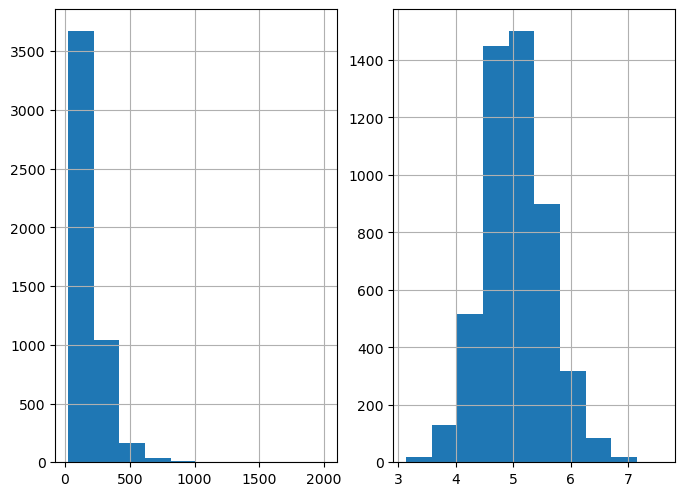

rsquared of y: 0.5696477534537507 , rsquared of ln(y): 0.66424257065734
host_acceptance_rate ( r = 0.07459339490342584 )
accommodates ( r = 0.6671767190097946 )
bathrooms ( r = 0.5206090823913927 )
bedrooms ( r = 0.6232871844714722 )
price ( r = 0.8960873560489293 )
maximum_nights_avg_ntm ( r = -0.04990770324684194 )
review_scores_rating ( r = 0.10143208725330646 )
response_time_num ( r = 0.10975642607539293 )
type_num ( r = 0.46812997011457536 )
host_verifications_num ( r = 0.031264652652906816 )
amenities_num ( r = 0.26315011107370884 )
host_duration ( r = -0.06717899728358293 )
popularity ( r = -0.09009500443833529 )
dist_attractions ( r = -0.1069354950302189 )
dist_city ( r = -0.20417210789579765 )
average_price ( r = 0.42486098438427683 )
poi_count ( r = 0.11088932094758325 )
transport_count ( r = 0.10229173798155645 )
cluster_id ( r = 0.6974745931568405 )
host_is_superhost_t ( r = 0.04921610653267982 )
instant_bookable_t ( r = 0.04434034154796674 )
license_tf_t ( r = 0.2000798768

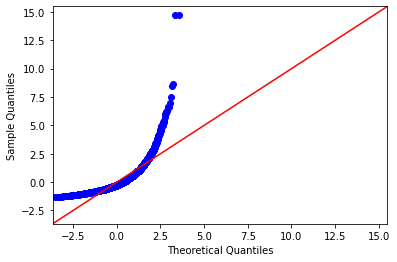

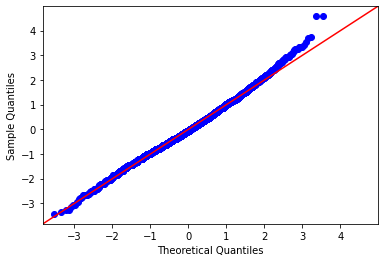

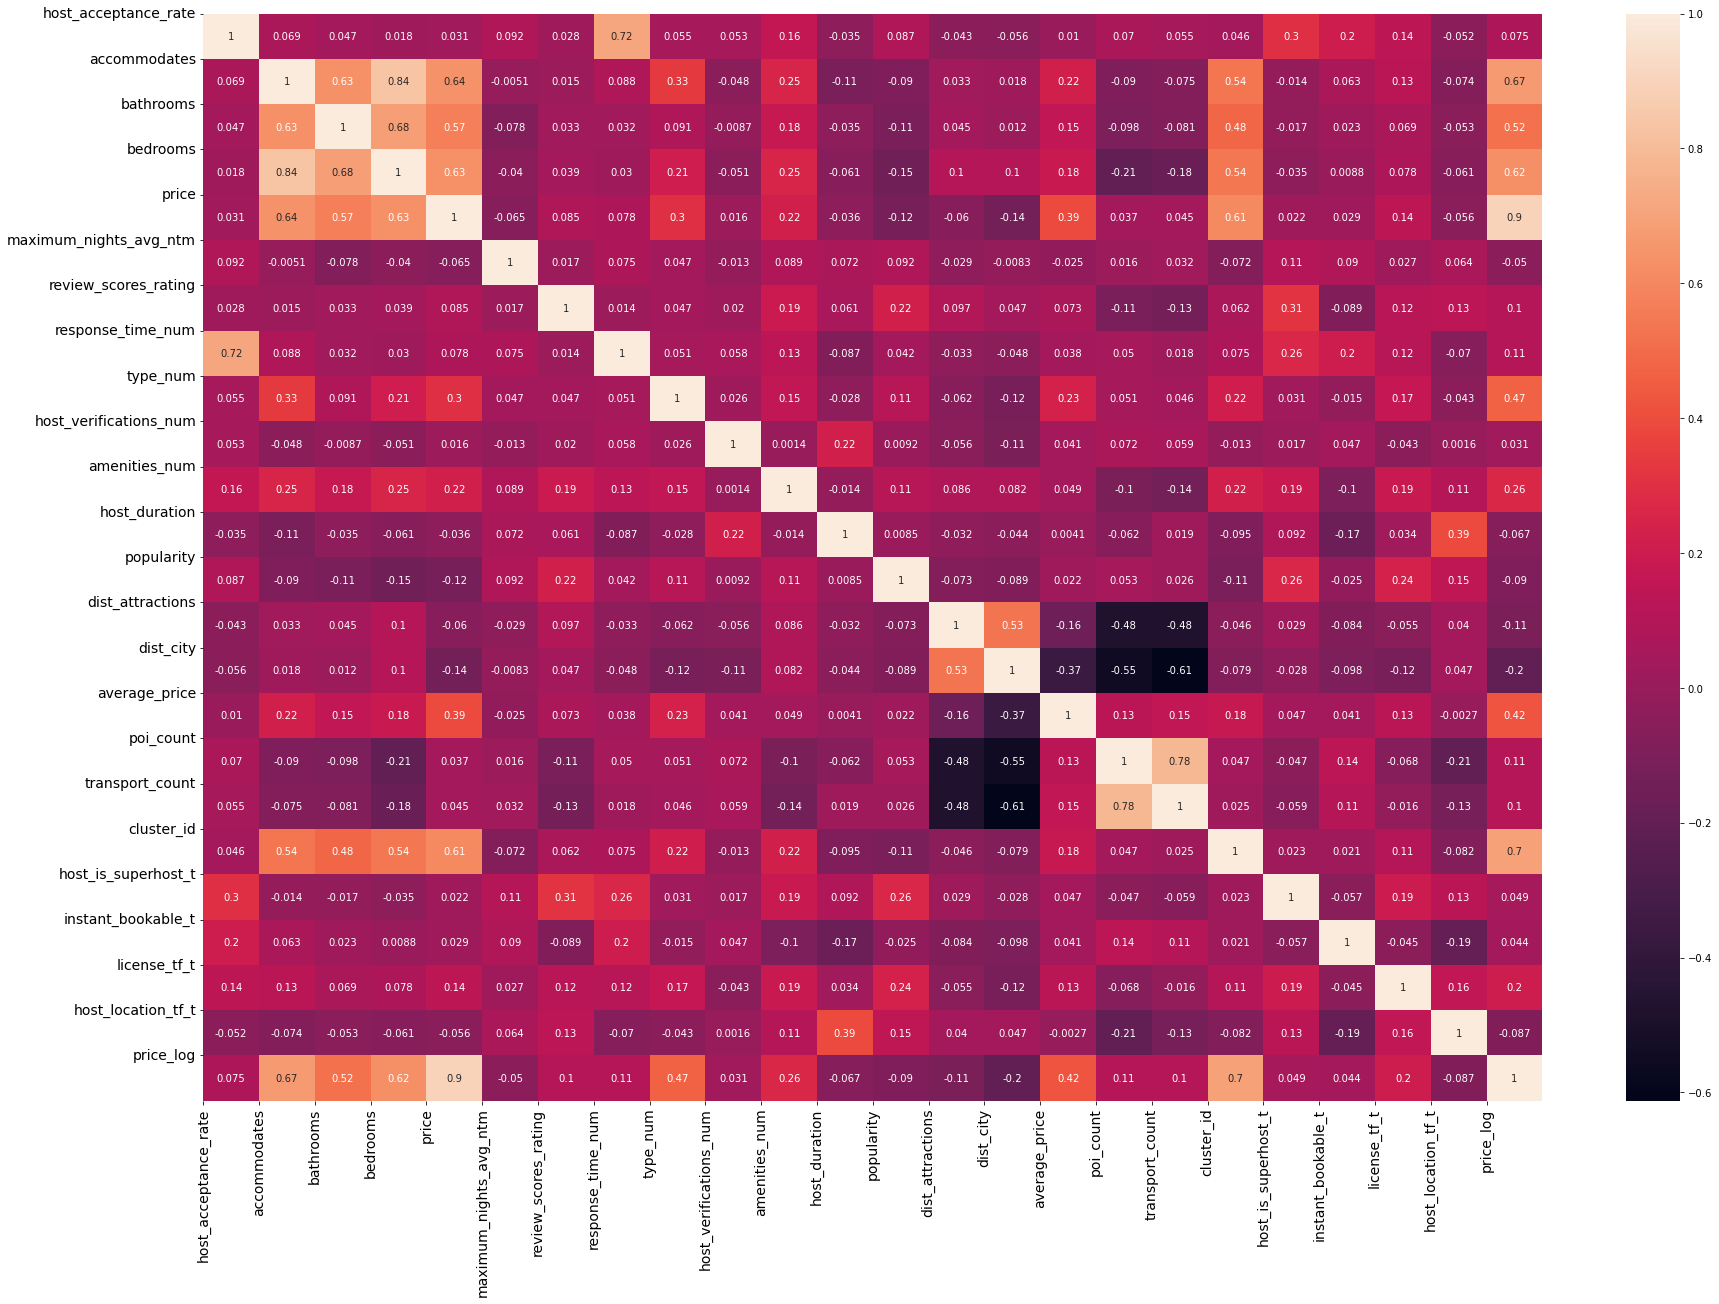

In [115]:
#Variable Selection

#Data Preparation and Clean
seattle_dum = pd.get_dummies(class_price)
seattle = seattle_dum.drop(labels=['OID_','id','host_id','host_response_rate','calculated_host_listings_count','beds','airbnb_count','hotel_count','review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value','latitude', 'longitude','relative_price','pop_past','pop_future','host_is_superhost_f','host_has_profile_pic_f','host_identity_verified_f','instant_bookable_f','license_tf_f','host_location_tf_f'], axis=1)

#Def VIF
def drop_column_using_vif_(df, thresh=5):
    while True:
        df_with_const = add_constant(df)
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()
        vif_df = vif_df.drop('const')
        if vif_df.VIF.max() > thresh:
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            break
    return df

#VIF
seattle = seattle.dropna(axis=0, how = 'any')
seattle_VIF = drop_column_using_vif_(seattle)
print(seattle_VIF.columns)

#Normality Test
kstest = scipy.stats.kstest(seattle_VIF['price'],cdf = "norm")
normaltest = scipy.stats.normaltest(seattle_VIF['price'])
print(kstest)
print(normaltest)
#ln(y) and Compare it with y 
if kstest.pvalue < 0.05 and normaltest.pvalue < 0.05:
    seattle_VIF['price_log'] = ""
    seattle_VIF['price_log'] = seattle_VIF['price'].apply(np.log)
#Plot the Difference
plt.figure(dpi=100,figsize=(8,6))
plt.subplot(1,2,1)
seattle_VIF['price'].hist()
plt.subplot(1,2,2)
seattle_VIF['price_log'].hist()
plt.show()
#qqplot拟合曲线
sm.qqplot(seattle_VIF['price'], fit=True, line='45')
sm.qqplot(seattle_VIF['price_log'], fit=True, line='45')
#Show the Difference of rsquare
y = sm.OLS(endog = seattle_VIF['price'], exog = sm.add_constant(seattle_VIF.drop(labels=['cluster_id','price','price_log'], axis=1))).fit()
spatial_analysis['price'] = np.log1p(spatial_analysis['price'])
yrsq = y.rsquared
lny = sm.OLS(endog = seattle_VIF['price_log'], exog = sm.add_constant(seattle_VIF.drop(labels=['cluster_id','price','price_log'], axis=1))).fit()
lnyrsq = lny.rsquared
print("rsquared of y:",yrsq,", rsquared of ln(y):",lnyrsq)

#Pearson Correlation Coefficient
seattle_corr = seattle_VIF
for i in range(len(seattle_VIF.columns)):
    pearson = pearsonr(seattle_VIF[seattle_VIF.columns[i]], seattle_VIF['price_log'])
    if pearson[1] < 0.05:
        print(seattle_VIF.columns[i],"( r =",pearson[0],")")
    else:
        seattle_corr = seattle_corr.drop(labels=[seattle_VIF.columns[i]], axis=1)
#Checking the Correlation Between Variables
f = plt.figure(figsize=(30, 20))
sn.heatmap(seattle_corr.corr(),annot=True)
plt.xticks(range(seattle_corr.shape[1]), seattle_corr.columns, fontsize=14, rotation=90)
plt.yticks(range(seattle_corr.shape[1]), seattle_corr.columns, fontsize=14)
plt.show()

In [116]:
#OLS_price
OLS_y = seattle_corr['price_log']
OLS_x = seattle_corr.drop(labels=['price','price_log','cluster_id'], axis=1)
OLS_price = sm.OLS(endog = OLS_y, exog = sm.add_constant(OLS_x)).fit()
OLS_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     462.0
Date:                 周一, 12 12月 2022   Prob (F-statistic):               0.00
Time:                        03:52:51   Log-Likelihood:                -1426.7
No. Observations:                4932   AIC:                             2897.
Df Residuals:                    4910   BIC:                             3041.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.1607      0.087     24.856      0.000       1.990       2.331
host_acceptance_rate      -0.0010      0.000     -3.882      0.000      -0.002      -0.000
accommodates               0.0457      0.004     12.416      0.000       0.038       0.053
bathrooms                  0.1139      0.009     12.053      0.000       0.095       0.132
bedrooms                   0.1294      0.008     15.427      0.000       0.113       0.146
maximum_nights_avg_ntm -4.841e-05      1e-05     -4.823      0.000   -6.81e-05   -2.87e-05
review_scores_rating       0.1171      0.015      7.943      0.000       0.088       0.146
response_time_num          0.0255      0.006      4.581      0.000       0.015       0.036
type_num                   0.3891      0.014     27.785      0.000       0.362       0.417
host_verifications_num     0.0357      0.011      3.290      0.001       0.014       0.057
amenities_num              0.0032      0.000      8.292      0.000       0.002       0.004
host_duration          -7.859e-06   4.89e-06     -1.609      0.108   -1.74e-05    1.72e-06
popularity                -0.0437      0.004    -12.069      0.000      -0.051      -0.037
dist_attractions       -8.273e-06   3.67e-06     -2.257      0.024   -1.55e-05   -1.09e-06
dist_city              -7.412e-06   1.84e-06     -4.020      0.000    -1.1e-05    -3.8e-06
average_price              0.0023      0.000     19.876      0.000       0.002       0.002
poi_count                  0.0005   4.77e-05      9.502      0.000       0.000       0.001
transport_count            0.0008      0.001      1.070      0.285      -0.001       0.002
host_is_superhost_t        0.0404      0.011      3.798      0.000       0.020       0.061
instant_bookable_t         0.0103      0.010      1.026      0.305      -0.009       0.030
license_tf_t               0.1085      0.012      8.889      0.000       0.085       0.132
host_location_tf_t        -0.0135      0.012     -1.107      0.268      -0.037       0.010
==============================================================================
Omnibus:                      425.362   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1287.302
Skew:                           0.448   Prob(JB):                    2.92e-280
Kurtosis:                       5.337   Cond. No.                     1.50e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

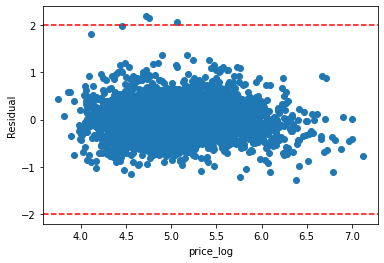

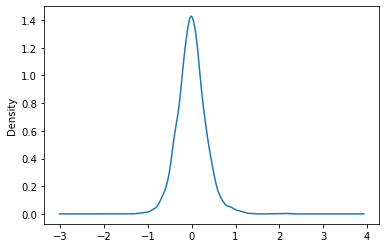

KstestResult(statistic=0.2611894684794409, pvalue=2.4637834478438078e-297)
NormaltestResult(statistic=425.3620155124059, pvalue=4.3034020841633794e-93)
0.04805352798053528


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     639.7
Date:                 周一, 12 12月 2022   Prob (F-statistic):               0.00
Time:                        03:53:10   Log-Likelihood:                -392.79
No. Observations:                4695   AIC:                             829.6
Df Residuals:                    4673   BIC:                             971.6
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.2375      0.074     30.344      0.000       2.093       2.382
host_acceptance_rate      -0.0006      0.000     -2.611      0.009      -0.001      -0.000
accommodates               0.0443      0.003     14.183      0.000       0.038       0.050
bathrooms                  0.1306      0.009     14.691      0.000       0.113       0.148
bedrooms                   0.1265      0.007     17.612      0.000       0.112       0.141
maximum_nights_avg_ntm -3.839e-05    8.4e-06     -4.568      0.000   -5.49e-05   -2.19e-05
review_scores_rating       0.0981      0.012      7.900      0.000       0.074       0.122
response_time_num          0.0172      0.005      3.673      0.000       0.008       0.026
type_num                   0.4107      0.012     34.434      0.000       0.387       0.434
host_verifications_num     0.0268      0.009      2.957      0.003       0.009       0.045
amenities_num              0.0037      0.000     11.325      0.000       0.003       0.004
host_duration          -6.905e-06   4.09e-06     -1.687      0.092   -1.49e-05    1.12e-06
popularity                -0.0383      0.003    -12.697      0.000      -0.044      -0.032
dist_attractions       -1.347e-05   3.06e-06     -4.404      0.000   -1.95e-05   -7.47e-06
dist_city               -6.89e-06   1.54e-06     -4.461      0.000   -9.92e-06   -3.86e-06
average_price              0.0020   9.98e-05     19.902      0.000       0.002       0.002
poi_count                  0.0004   3.97e-05     11.227      0.000       0.000       0.001
transport_count            0.0004      0.001      0.682      0.495      -0.001       0.002
host_is_superhost_t        0.0391      0.009      4.399      0.000       0.022       0.057
instant_bookable_t         0.0037      0.008      0.443      0.658      -0.013       0.020
license_tf_t               0.1161      0.010     11.314      0.000       0.096       0.136
host_location_tf_t        -0.0379      0.010     -3.704      0.000      -0.058      -0.018
==============================================================================
Omnibus:                       45.247   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.317
Skew:                           0.052   Prob(JB):                     2.61e-07
Kurtosis:                       2.620   Cond. No.                     1.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [117]:
#Diagnose the model using residual analysis
plt.scatter(OLS_price.fittedvalues, OLS_price.resid)
plt.xlabel('price_log')
plt.ylabel('Residual')
plt.axhline(y=2, color='r', linestyle='--')
plt.axhline(y=-2, color='r', linestyle='--') 
plt.show()

#残差分析正态性检验
plt.figure()
OLS_price.resid.plot.density()
plt.show()
kstest = scipy.stats.kstest(OLS_price.resid,cdf = "norm")
normaltest = scipy.stats.normaltest(OLS_price.resid)
print(kstest)
print(normaltest)

#残差方齐性检验
#第一个值为LM统计量；第二个值是统计量对应的概率p值；第三个值为F统计量，用于检验残差平方项与自变量之间是否独立，如果独立则表明残差方差齐性；第四个值则为F统计量的概率p值，同样大于0.05，则进一步表示残差项满足方差齐性的假设。
BP_test = statsmodels.stats.diagnostic.het_breuschpagan(exog_het = OLS_x, resid = OLS_price.resid)

#Outlier test
outliers = OLS_price.get_influence()
leverage = outliers.hat_matrix_diag
dffts = outliers.dffits[0]
resid_stu = outliers.resid_studentized_external
cook =outliers.cooks_distance[0]
contat = pd.concat([pd.Series(leverage,name = "leverage"),pd.Series(dffts,name = "dffts"),pd.Series(resid_stu,name = "resid_stu"),pd.Series(cook,name = "cook")],axis = 1)
seattle_corr.index = range(seattle_corr.shape[0])
OLS_price_outliers = pd.concat([seattle_corr,contat],axis = 1)
OLS_price_outliers.head()

#Calculating outlier ratios and outlier handling
outliers_ratio = sum(np.where((np.abs(OLS_price_outliers.resid_stu)>2),1,0))/OLS_price_outliers.shape[0]
print(outliers_ratio)
if outliers_ratio < 0.05:
    none_outliers = seattle_corr.loc[np.abs(OLS_price_outliers.resid_stu)<=2,]

#Re-OLS
OLS1_y = none_outliers['price_log']
OLS1_x = none_outliers.drop(labels=['price','price_log','cluster_id'], axis=1)
OLS1_price = sm.OLS(endog = OLS1_y, exog = sm.add_constant(OLS1_x)).fit()
OLS1_price.summary()

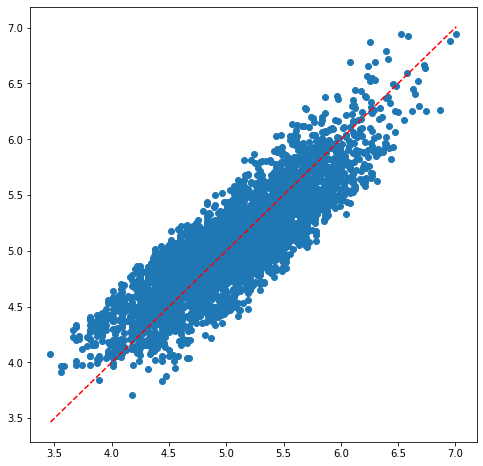

"\n#输出影响显著且解释度>5%的一元线性回归图和影响显著的值\ndef rm(indep):\n    rm = sm.OLS(endog = none_outliers['price_log'], exog = sm.add_constant(none_outliers[indep])).fit()\n    beta_0, beta_1 = rm.params\n    rsq    = rm.rsquared\n    pval_0, pval_1 = rm.pvalues\n    if rsq > 0.05 and pval_1 < 0.05:\n        fig, ax = plt.subplots()\n        none_outliers.plot(kind='scatter', x=indep, y='price_log', figsize=(9, 9), ax = ax)\n        X = none_outliers.eval(indep)\n        b = plt.plot(X, X*beta_1 + beta_0, 'r')\n    if pval_1 < 0.05:\n        print(indep)\n\nindepdent = none_outliers.columns\nfor i in range(len(indepdent)):\n    rm(indep = indepdent[i])\n"

In [118]:
#回归拟合
fig, ax = plt.subplots(figsize=(8,8))
predict = OLS1_price.fittedvalues
pd.DataFrame({"Prediction":predict,"Real":OLS1_y})
plt.scatter(x = OLS1_y, y = predict) 
plt.plot([OLS1_y.min(),OLS1_y.max()],[OLS1_y.min(),OLS1_y.max()],color = "red", linestyle = "--")
plt.show()

'''
#输出影响显著且解释度>5%的一元线性回归图和影响显著的值
def rm(indep):
    rm = sm.OLS(endog = none_outliers['price_log'], exog = sm.add_constant(none_outliers[indep])).fit()
    beta_0, beta_1 = rm.params
    rsq    = rm.rsquared
    pval_0, pval_1 = rm.pvalues
    if rsq > 0.05 and pval_1 < 0.05:
        fig, ax = plt.subplots()
        none_outliers.plot(kind='scatter', x=indep, y='price_log', figsize=(9, 9), ax = ax)
        X = none_outliers.eval(indep)
        b = plt.plot(X, X*beta_1 + beta_0, 'r')
    if pval_1 < 0.05:
        print(indep)

indepdent = none_outliers.columns
for i in range(len(indepdent)):
    rm(indep = indepdent[i])
'''

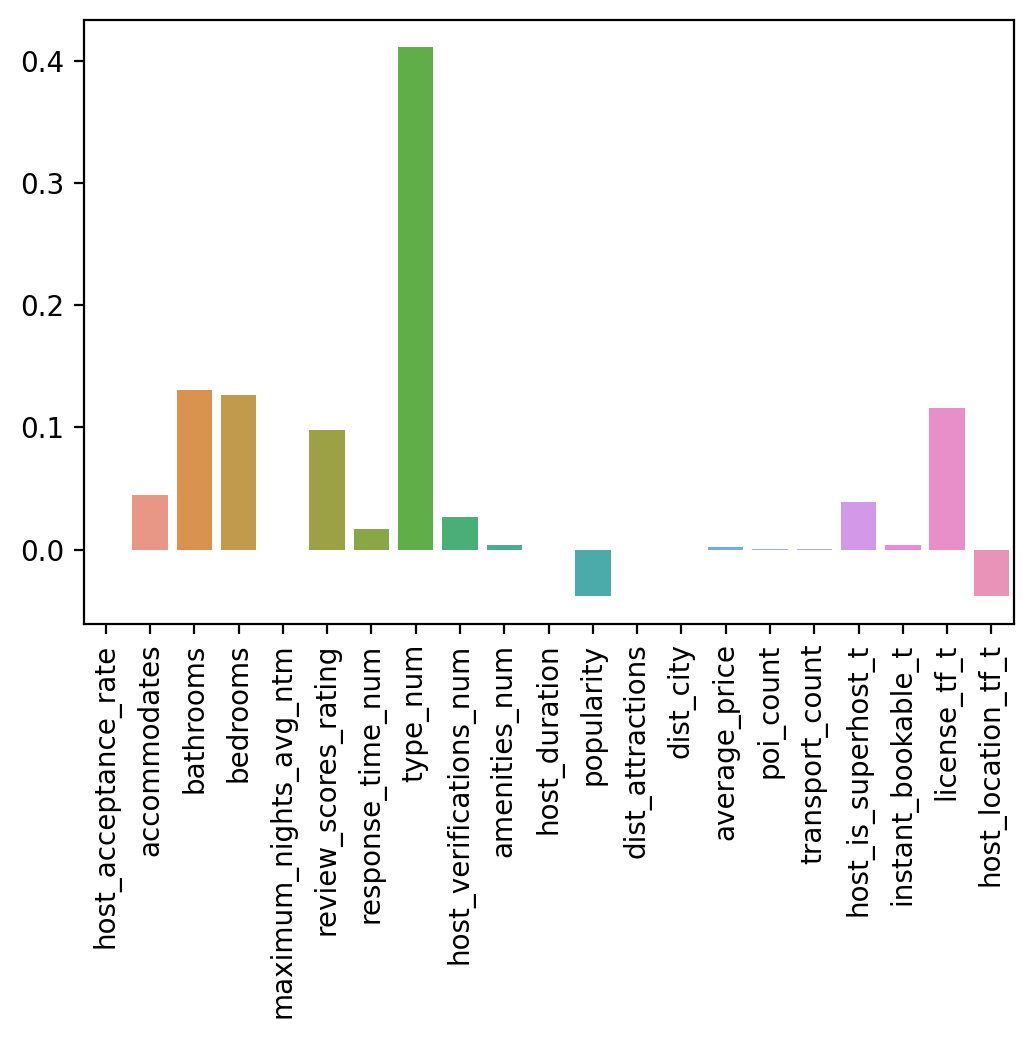

[-6.89044602854377e-06, -6.9051568240551415e-06, -1.3470433223586126e-05, -3.838604773483103e-05, 0.0004320583885762065, 0.00044572528297605763, -0.0005742738956457904, 0.001985853743682958, 0.003698843432590916, 0.003706030660876769, 0.017179428616621226, 0.026826816289361274, -0.0378767984092232, -0.0383241730306092, 0.0391372895707303, 0.0443104479967104, 0.09812983773397604, 0.1161363525437712, 0.12649653491259588, 0.13064120330374457, 0.4107462862953241]
['dist_city', 'host_duration', 'dist_attractions']
['review_scores_rating', 'license_tf_t', 'bedrooms', 'bathrooms', 'type_num']
host_acceptance_rate     -0.000574
accommodates              0.044310
bathrooms                 0.130641
bedrooms                  0.126497
maximum_nights_avg_ntm   -0.000038
review_scores_rating      0.098130
response_time_num         0.017179
type_num                  0.410746
host_verifications_num    0.026827
amenities_num             0.003699
host_duration            -0.000007
popularity            

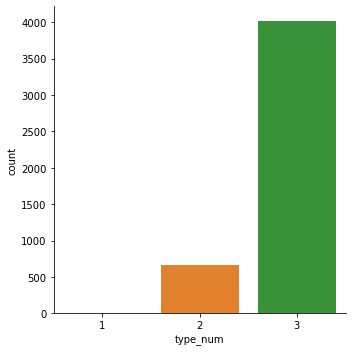

<Figure size 2000x1800 with 0 Axes>

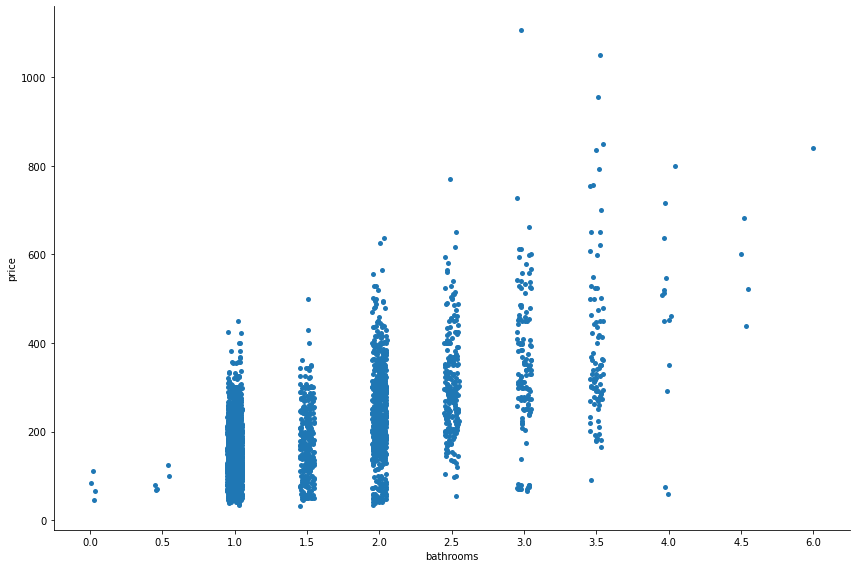

1.0    2259
2.0    1120
3.0     556
0.0     502
4.0     162
5.0      69
6.0      18
7.0       8
8.0       1
Name: bedrooms, dtype: int64


<Figure size 2000x1800 with 0 Axes>

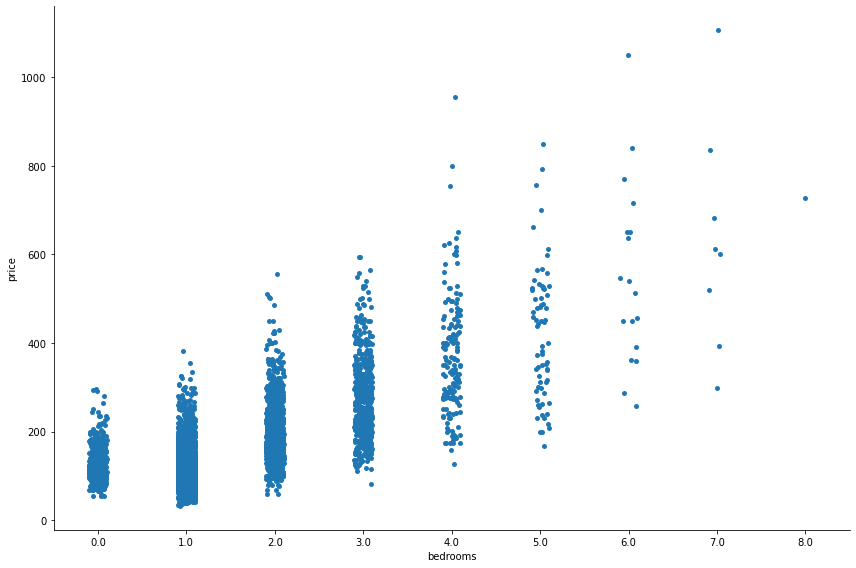

1    3703
0     992
Name: license_tf_t, dtype: int64
license_tf_t
0    21.12886
1    78.87114
dtype: float64


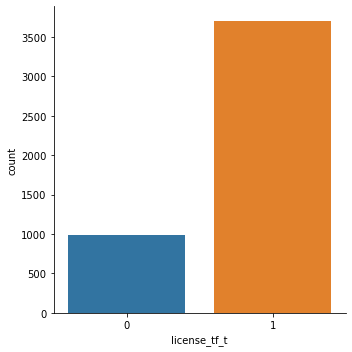

<Figure size 60000x1800 with 0 Axes>

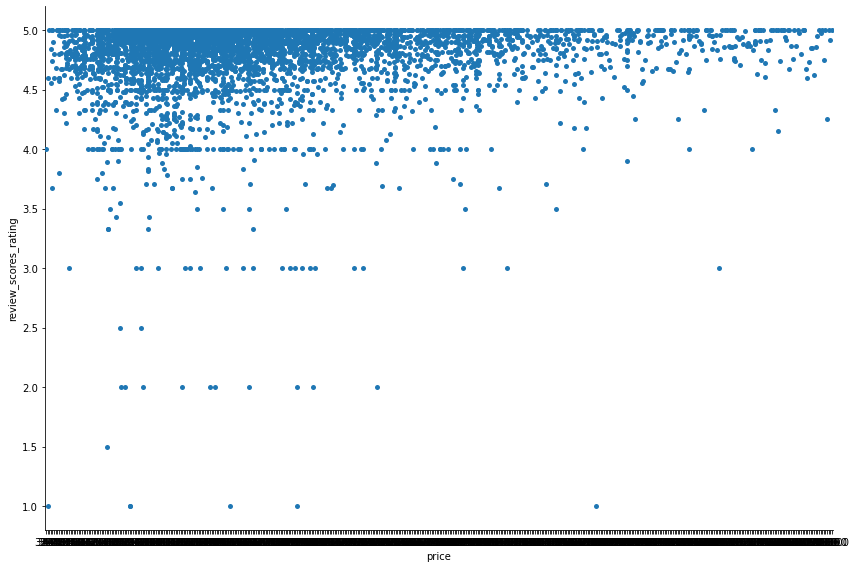

<Figure size 60000x1800 with 0 Axes>

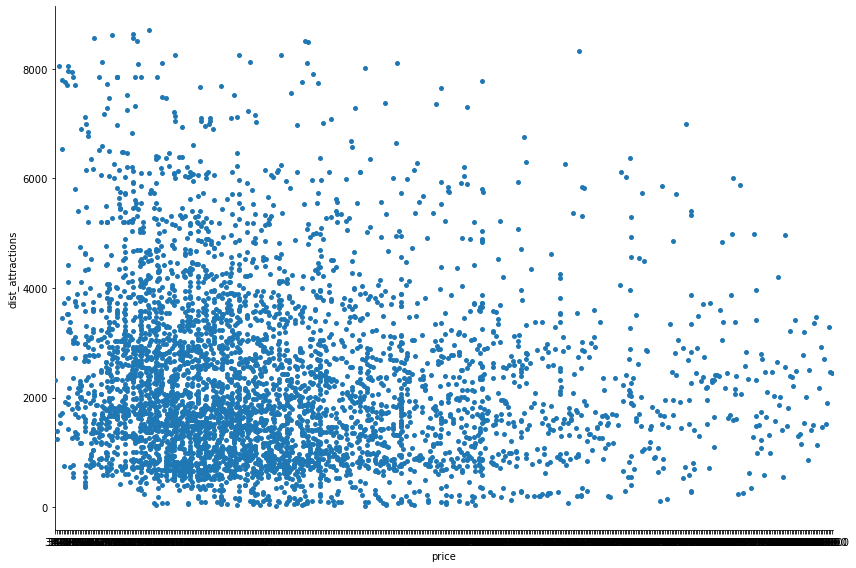

<Figure size 60000x1800 with 0 Axes>

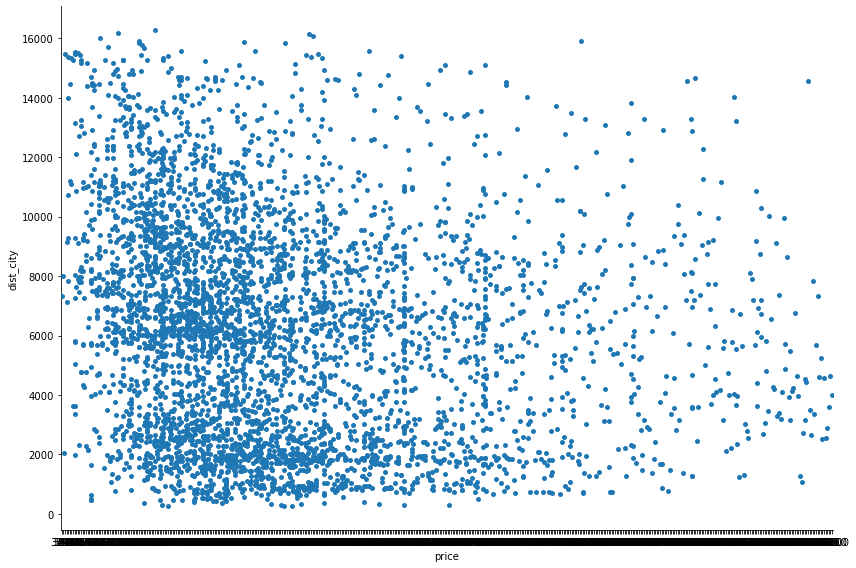

<Figure size 60000x1800 with 0 Axes>

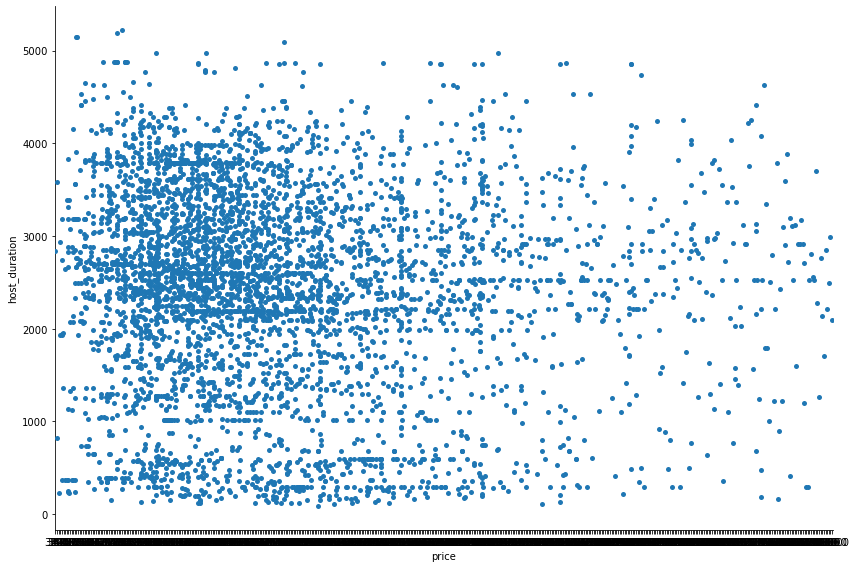

In [119]:
#对回归系数进行标准化和排序
feature_imp = OLS1_price.params.iloc[1:]
feature_imp.abs().sort_values()
#Plot
plt.figure(dpi=200)
sn.barplot(x = feature_imp.index,y = feature_imp.values)
plt.xticks(rotation=90)
plt.show()

# 选择影响最大的五项和最小的三项，影响最小的三个只需要简单描述，影响最大的五个后面会更细化的讨论
# 最小的三项
print(sorted(feature_imp,key=abs))
imp_min = feature_imp.abs().sort_values().head(3).index.to_list()
imp_max = feature_imp.abs().sort_values().tail(5).index.to_list()
print(imp_min)
print(imp_max)
print(feature_imp)

#type_num
#不同房间类型的数量
type_num = none_outliers['type_num'].value_counts()
print(type_num)
#将每种房间类型的统计数量转化成百分比形式
type_num = none_outliers.groupby('type_num').size() / none_outliers['type_num'].count() * 100
print(type_num)
# 绘制直方图查看房型数量
sn.catplot(x = 'type_num',  kind='count', data = none_outliers)
fig = plt.gca()
fig.set()

#bathrooms
bathrooms = none_outliers['bathrooms'].value_counts()
print(bathrooms)
#price与bathrooms数量的关系
plt.figure(figsize=(10,9),dpi=200)
sn.catplot(data= none_outliers,x='bathrooms',y='price',height=8, aspect=1.5)
plt.show()

#bedrooms
bedrooms = none_outliers['bedrooms'].value_counts()
print(bedrooms)
#price与bedrooms数量的关系
plt.figure(figsize=(10,9),dpi=200)
sn.catplot(data = none_outliers,x='bedrooms',y='price',height=8, aspect=1.5)
plt.show()

#license_tf_t
#不同房间类型的数量
license_tf_t = none_outliers['license_tf_t'].value_counts()
print(license_tf_t)
#将每种房间类型的统计数量转化成百分比形式
license_tf_t = none_outliers.groupby('license_tf_t').size() / none_outliers['license_tf_t'].count() * 100
print(license_tf_t)
# 绘制直方图查看房型数量
sn.catplot(x = 'license_tf_t',  kind='count', data = none_outliers)
fig = plt.gca()
fig.set()

#review_scores_rating
review_scores_rating = none_outliers['review_scores_rating'].value_counts()
#review_scores_rating和price的散点图
plt.figure(figsize=(300,9),dpi=200)
sn.catplot(data=none_outliers,x = 'price',y = 'review_scores_rating',height=8, aspect=1.5)
plt.show()

#dist_attractions
dist_attractions = none_outliers['dist_attractions'].value_counts()
#绘制dist_attrctions和price关系的散点图
plt.figure(figsize=(300,9),dpi=200)
sn.catplot(data=none_outliers,x = 'price',y = 'dist_attractions',height=8, aspect=1.5)
plt.show() 

#dist_city
dist_attractions = none_outliers['dist_city'].value_counts()
#绘制dist_city和price关系的散点图
plt.figure(figsize=(300,9),dpi=200)
sn.catplot(data=none_outliers,x = 'price',y = 'dist_city',height=8, aspect=1.5)
plt.show() 

#host_duration
dist_attractions = none_outliers['host_duration'].value_counts()
#绘制host_duration和price关系的散点图
plt.figure(figsize=(300,9),dpi=200)
sn.catplot(data=none_outliers,x = 'price',y = 'host_duration',height=8, aspect=1.5)
plt.show() 

Text(0, 0.5, '')

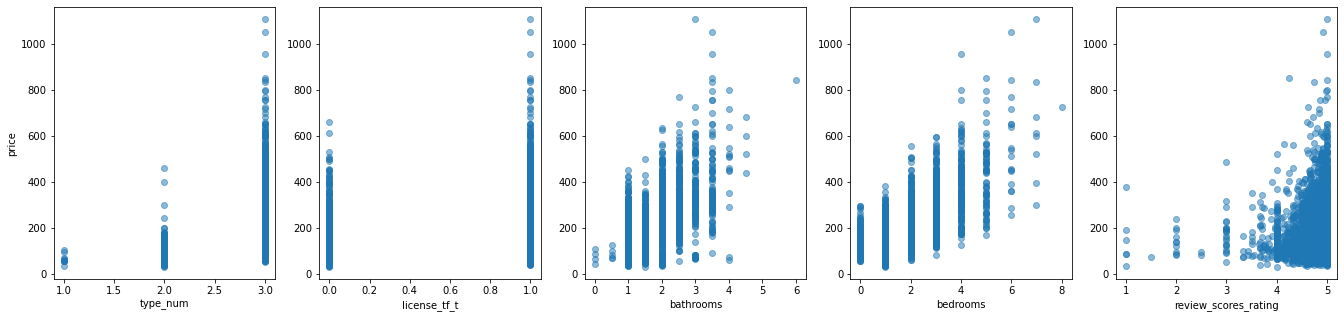

In [120]:
# Scatter plot of influencing factors significantly related to price

fig,ax=plt.subplots(1,5,figsize=(23,5))
ax[0].scatter(x = none_outliers['type_num'],y = none_outliers['price'],alpha=.5)
ax[0].set_xlabel(xlabel = 'type_num')
ax[0].set_ylabel(ylabel = 'price')

ax[1].scatter(x = none_outliers['license_tf_t'],y = none_outliers['price'],alpha = .5)
ax[1].set_xlabel(xlabel='license_tf_t')
ax[1].set_ylabel(ylabel='')

ax[2].scatter(x = none_outliers['bathrooms'],y = none_outliers['price'],alpha = .5)
ax[2].set_xlabel(xlabel = 'bathrooms')
ax[2].set_ylabel(ylabel = '')

ax[3].scatter(x = none_outliers['bedrooms'],y = none_outliers['price'],alpha = .5)
ax[3].set_xlabel(xlabel = 'bedrooms')
ax[3].set_ylabel(ylabel = '')

ax[4].scatter(x = none_outliers['review_scores_rating'],y = none_outliers['price'],alpha=.5)
ax[4].set_xlabel(xlabel = 'review_scores_rating')
ax[4].set_ylabel(ylabel = '')

Text(0, 0.5, '')

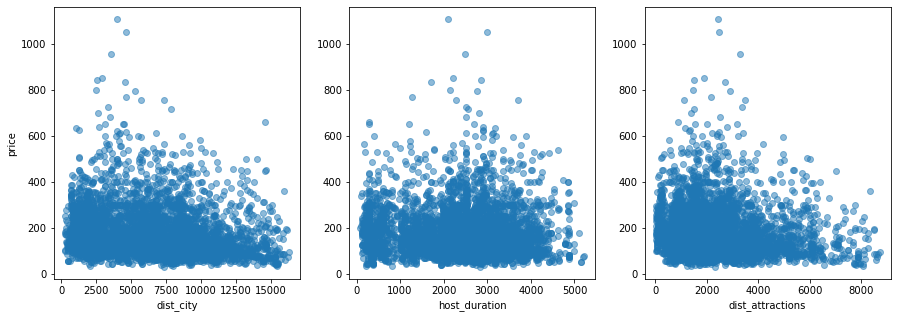

In [121]:
#Scatter plot of influencing factors significantly related to price

fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(x = none_outliers['dist_city'],y = none_outliers['price'],alpha=.5)
ax[0].set_xlabel(xlabel = 'dist_city')
ax[0].set_ylabel(ylabel = 'price')

ax[1].scatter(x = none_outliers['host_duration'],y = none_outliers['price'],alpha = .5)
ax[1].set_xlabel(xlabel='host_duration')
ax[1].set_ylabel(ylabel='')

ax[2].scatter(x = none_outliers['dist_attractions'],y = none_outliers['price'],alpha = .5)
ax[2].set_xlabel(xlabel = 'dist_attractions')
ax[2].set_ylabel(ylabel = '')

In [8]:
test = pd.read_csv("https://raw.githubusercontent.com/XianlaiYin/Data/main/class_price.csv")
print("count of lower price =", len(test[test["cluster_id"] == 0]))
print("count of medium price =", len(test[test["cluster_id"] == 2]))
print("count of higher price =", len(test[test["cluster_id"] == 1]))


count of lower price = 3490
count of medium price = 1285
count of higher price = 157
